In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier

# Data Cleaning

In [2]:
# chunk_size = 100000

# csv_chunks = pd.read_csv('US_Accidents_March23.csv', chunksize=chunk_size)

# all_chunks = [] 
# for i, chunk in enumerate(csv_chunks):

#     cols_to_keep = ['Severity', 'Temperature(F)', 'Wind_Chill(F)', 
#                     'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 
#                     'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition']

#     df = chunk[cols_to_keep]
#     df = df.fillna(0)

#     all_chunks.append(df)

#     if i == 5:
#         break
# df = pd.concat(all_chunks)

In [3]:
df = pd.read_csv('ignorefolder/cleaned_US_Accidents.csv', index_col=0)
data = pd.get_dummies(df, drop_first=True, dtype=np.int64)
X = data.drop(columns=['Severity'])
y = data['Severity']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

## Data Visualization

In [4]:
# plt.hist(df['Temperature(F)'], bins=50)
# plt.show()
# plt.hist(df['Wind_Chill(F)'], bins=50)
# plt.show()
# plt.hist(df['Humidity(%)'], bins=50)
# plt.show()
# plt.hist(df['Pressure(in)'], bins=50)
# plt.show()
# plt.hist(df['Visibility(mi)'], bins=50)
# plt.show()
# plt.hist(df['Wind_Direction'], bins=50)
# plt.show()
# plt.hist(df['Wind_Speed(mph)'], bins=50)
# plt.show()
# plt.hist(df['Precipitation(in)'], bins=50)
# plt.show()
# plt.hist(df['Weather_Condition'], bins=50)

# Random Forest

In [5]:
# Initialize and fit the forest
rf = RandomForestClassifier(oob_score=True)
rf.fit(X_train, y_train)

# Print the oob_score
print(rf.oob_score_)

# Extract the feature importances of the forest
feature_importances = rf.feature_importances_
feature_names = X.columns

features = sorted(zip(feature_importances, feature_names))


print(f'Best Features {features[-3:]}')
print(f'Worst Features {features[:3]}')

0.7625285052910945
Best Features [(0.13276559458058498, 'Temperature(F)'), (0.14748745635195631, 'Humidity(%)'), (0.16774186415324846, 'Pressure(in)')]
Worst Features [(0.0, 'Turning_Loop'), (0.0, 'Weather_Condition_Heavy Freezing Drizzle'), (0.0, 'Weather_Condition_Heavy Rain Shower / Windy')]


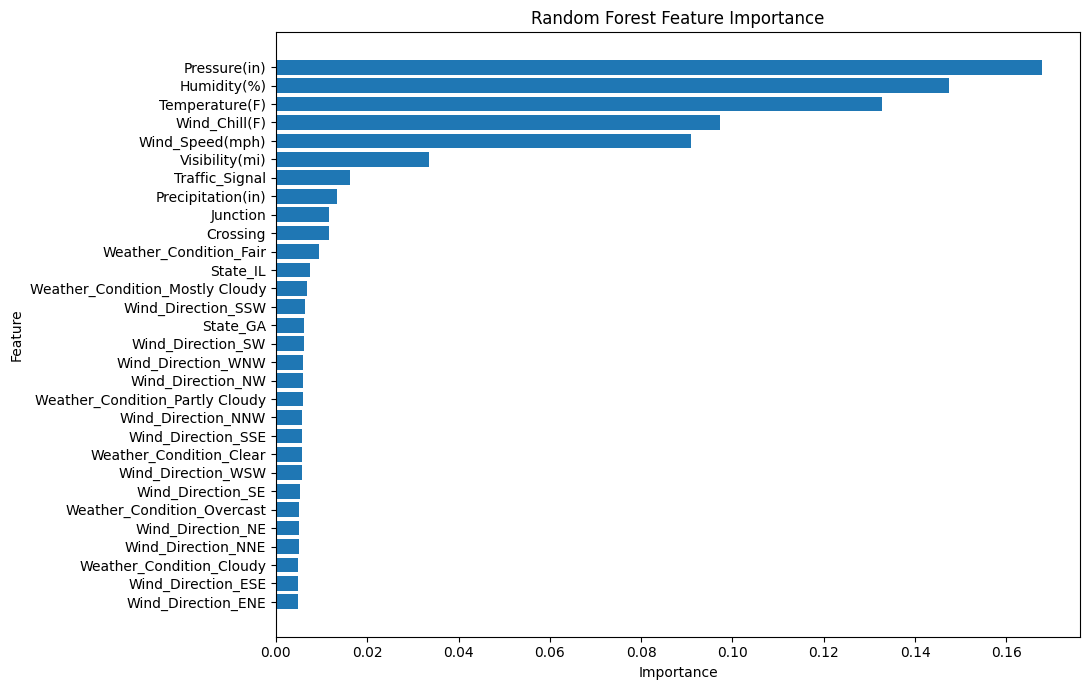

In [14]:
importances = rf.feature_importances_
k = len(importances) // 7
indices = np.argsort(importances)[-k:]

plt.figure(figsize=(11, 7))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('figures/rf_feature_importance')

In [7]:
# # Decide what values of max_depth and max_features to search over
# max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# max_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# best_oob_score = 0
# best_params = None



# # Perform a grid search to find the best parameters
# for max_depth in max_depths:
#   for mf in max_features:
#     # Initialize and fit the forest
#     rf = RandomForestClassifier(oob_score=True, max_depth=max_depth, max_features=mf)
#     rf.fit(X_train, y_train)
      
      
#     # Compare the oob_score to your best oob_score and store the parameters if better
#     if best_oob_score < rf.oob_score_:
#       best_oob_score = rf.oob_score_
#       best_params = max_depth, mf

# # Print the best oob score and the hyperparameters you used to get it
# print(best_oob_score)
# print(best_params)

# Boosting

In [8]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.7668472390230483


In [9]:
# Extract the feature importances of the forest
feature_importances = gb.feature_importances_
feature_names = X.columns

features = sorted(zip(feature_importances, feature_names))


print(f'Best Features {features[-3:]}')
print(f'Worst Features {features[:3]}')

Best Features [(0.08216923287494332, 'Pressure(in)'), (0.144526670790548, 'Traffic_Signal'), (0.21053664386365079, 'Wind_Chill(F)')]
Worst Features [(0.0, 'State_NH'), (0.0, 'State_NV'), (0.0, 'Turning_Loop')]


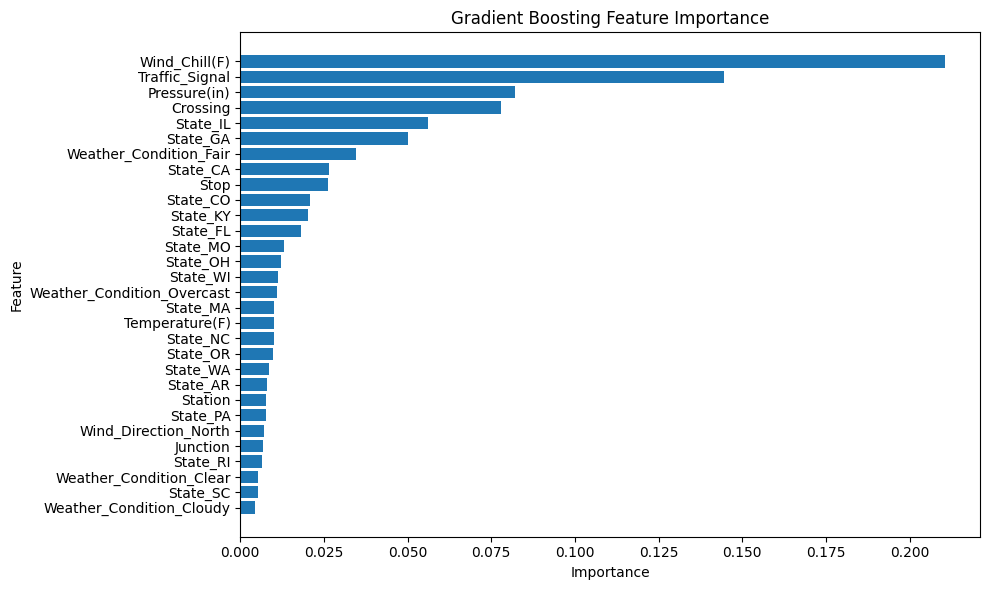

In [ ]:
importances = gb.feature_importances_
k = len(importances) // 7
indices = np.argsort(importances)[-k:]

plt.figure(figsize=(11, 7))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names[indices])
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig("figures/boosting_feature_importance")

# Bagging

In [11]:
bc = BaggingClassifier()

bc.fit(X_train, y_train)
accuracy = bc.score(X_test, y_test)
print(accuracy)

0.7551673497129587


In [12]:
# Extract the feature importances of the forest
feature_importances = bc.feature_importances_
feature_names = X.columns

features = sorted(zip(feature_importances, feature_names))


print(f'Best Features {features[-3:]}')
print(f'Worst Features {features[:3]}')

AttributeError: 'BaggingClassifier' object has no attribute 'feature_importances_'